In [1]:
# Package Imports - feel free to add what you think might be useful! 
%pip install numpy
%pip install matplotlib
import numpy as np 
import matplotlib.pyplot as plt 
import hashlib
import struct 
from collections import deque
import math

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Task 2: Tinkering with True Randomness
We've provided template classes for everything here. This task isn't meant to test your ability to write boilerplate code, rather we just want you to see the different environmental sources of entropy.

### Part A: Jitter-bug!

In [3]:
# Package Imports
import time # to be able to measure natural timing variations (jitter)
""" 
Important to Know:
time.perf_counter_ns() is our measurement function from the time package.
You will modify _collect_timing_jitter()
"""

' \nImportant to Know:\ntime.perf_counter_ns() is our measurement function from the time package.\nYou will modify _collect_timing_jitter()\n'

In [4]:
class JitterRNG:
    def __init__(self, pool_size=256):
        self.entropy_pool = deque(maxlen=pool_size)
        self.pool_size = pool_size
        self.last_time = None
    
    def _collect_timing_jitter(self, iterations=1000):
        """Collect entropy from timing variations between CPU operations"""
        jitter_data = []
        
        self.last_time = time.perf_counter_ns()
        
        for _ in range(iterations):
            """ 
            We need to introduce variability somehow. 
            In the following space, do some arbitrary computation to introduce variability.
            We're not going to judge this part. Just make it reasonable so your notebook
            doesn't take forever to run.
            """
            
            _ = math.sqrt(math.pow(math.pi, math.e) / math.pow(math.e, math.pi))

            current_time = time.perf_counter_ns()
            
            time_diff = current_time - self.last_time
            # hint: the JitterRNG class has a last_time attribute, 
            # and you just computed the current time.
            
            # Extract the least significant bits of the time difference
            # This is where the true randomness comes from
            lsb = time_diff & 0xFF # Get the lowest 8 bits of time_diff
            # hint: bitwise ops 
            jitter_data.append(lsb)

            self.last_time = current_time

        return jitter_data
    
    def fill_entropy_pool(self):
        """Fill the entropy pool with timing jitter data"""
        # Collect enough jitter samples to fill the pool
        jitter_data = self._collect_timing_jitter(self.pool_size)
        
        # Add to the entropy pool
        for value in jitter_data:
            self.entropy_pool.append(value)
        
        return jitter_data
    
    def get_random_bytes(self, num_bytes=32):
        """Generate random bytes using the entropy pool"""
        # Make sure we have enough entropy
        if len(self.entropy_pool) < self.pool_size:
            self.fill_entropy_pool()
        
        # Mix the entropy pool using SHA-256
        pool_bytes = bytes(self.entropy_pool)
        mixed_entropy = hashlib.sha256(pool_bytes).digest()
        
        # Create an output buffer
        result = bytearray()
        
        # Generate requested number of bytes
        while len(result) < num_bytes:
            # Add more entropy to the pool
            self.fill_entropy_pool()
            
            # Mix new entropy with previous hash
            pool_bytes = bytes(self.entropy_pool)
            h = hashlib.sha256()
            h.update(mixed_entropy)
            h.update(pool_bytes)
            mixed_entropy = h.digest()
            
            # Add to result
            result.extend(mixed_entropy)
        
        # Return only the requested number of bytes
        return bytes(result[:num_bytes])
    
    def get_random_int(self, min_val=0, max_val=100):
        """Generate a random integer between min_val and max_val (inclusive)"""
        # Calculate how many bytes we need
        range_size = max_val - min_val + 1
        if range_size <= 0:
            raise ValueError("Invalid range")
        
        # Calculate how many bits we need
        bits_needed = range_size.bit_length()
        bytes_needed = (bits_needed + 7) // 8
        
        # Get random bytes
        random_bytes = self.get_random_bytes(bytes_needed)
        
        # Convert bytes to integer
        value = int.from_bytes(random_bytes, byteorder='big')
        
        # Map to our range
        return min_val + (value % range_size)
    
    def analyze_randomness(self, sample_size=1000):
        """Analyze the randomness of the generator"""
        # Generate samples
        samples = []
        for _ in range(sample_size):
            samples.append(self.get_random_int(0, 255))
        
        # Create plots
        plt.figure(figsize=(12, 10))
        
        # Plot 1: Distribution histogram
        plt.subplot(2, 2, 1)
        plt.hist(samples, bins=32, color='blue', alpha=0.7)
        plt.title('Distribution of Random Values')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        
        # Plot 2: Sequential values
        plt.subplot(2, 2, 2)
        plt.plot(samples[:100], '.-', alpha=0.7)
        plt.title('First 100 Generated Values')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        
        # Plot 3: Scatter plot of consecutive values
        plt.subplot(2, 2, 3)
        plt.scatter(samples[:-1], samples[1:], alpha=0.5, s=5)
        plt.title('Scatter Plot of Consecutive Values')
        plt.xlabel('Value n')
        plt.ylabel('Value n+1')
        
        # Plot 4: Autocorrelation
        plt.subplot(2, 2, 4)
        autocorr = np.correlate(samples, samples, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        plt.plot(autocorr[:50])
        plt.title('Autocorrelation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        
        plt.tight_layout()
        plt.show()
        
        return samples

We can use our jitter-based randomness!

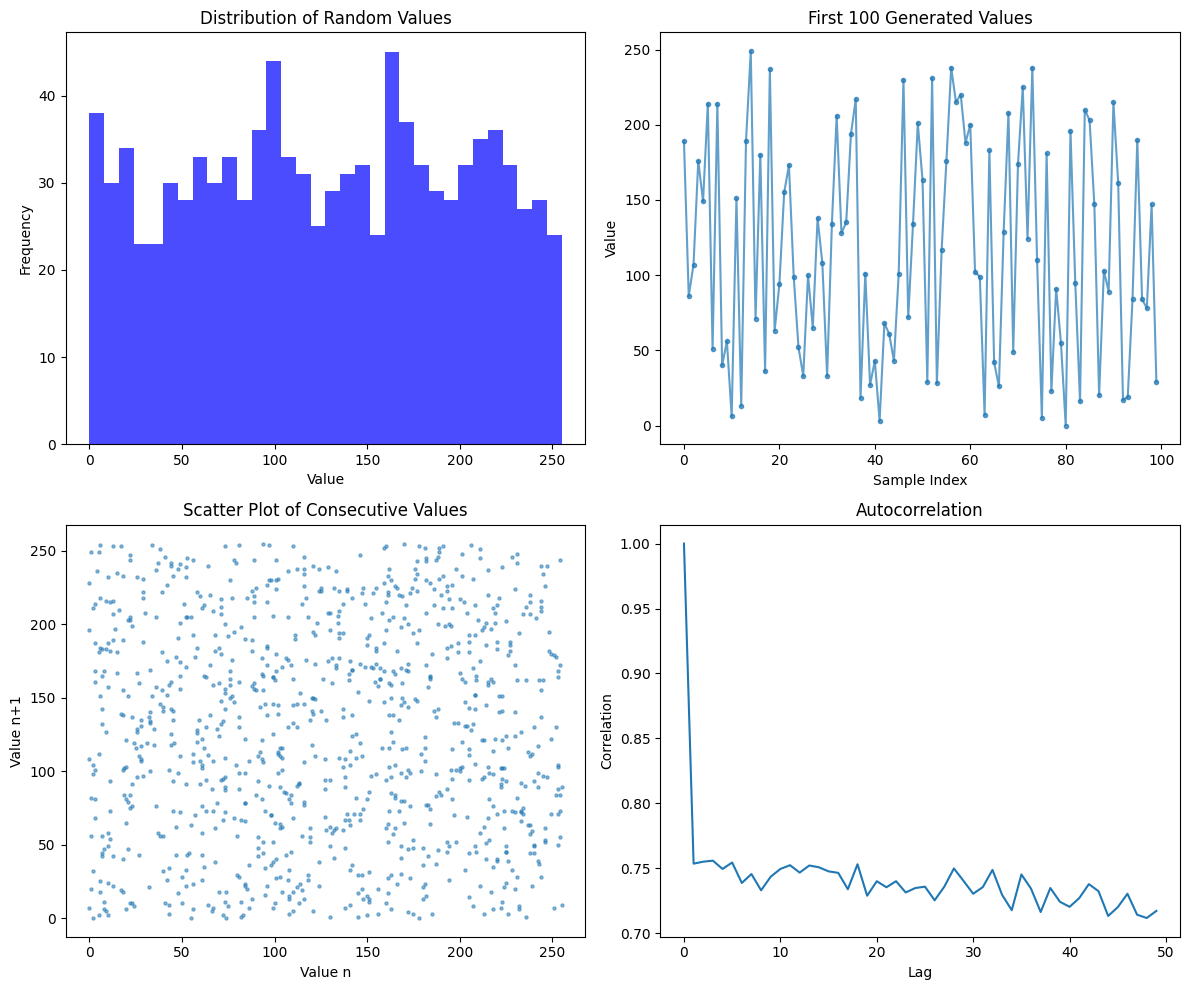

First 10 random numbers: [189, 86, 107, 176, 149, 214, 51, 214, 40, 56]
1000

Rolling a die 20 times:
3 5 6 6 2 1 2 5 4 1 6 4 4 5 3 4 6 4 2 3 

In [15]:
# Example usage
jitter_rng = JitterRNG()
random_data = jitter_rng.analyze_randomness(1000)
print(f"First 10 random numbers: {random_data[:10]}")

# Simulate rolling a die 20 times
print("\nRolling a die 20 times:")
for _ in range(20):
    print(jitter_rng.get_random_int(1, 6), end=" ")

In [16]:
# We try to predict the bits like in QRNGs and PRNGs.

import torch
import torch.nn as nn


class NextNumberPredictor(nn.Module):
    """
    Adapted from: https://medium.com/@gpj/predict-next-number-using-pytorch-47187c1b8e33.
    Modified to predict bits of random numbers instead of next numbers.
    """
    def __init__(self, layer_width, layer_depth):
        super(NextNumberPredictor, self).__init__()
        self.lstm = nn.LSTM(1, layer_width, layer_depth)
        self.fc = nn.Linear(layer_width, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

def train(model, data, num_epochs):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        for _input_sequence, _target in data:
            _input_sequence = torch.Tensor(_input_sequence).view(len(_input_sequence), -1)
            _target = torch.Tensor(_target).view(len(_target), -1)

            # Forward pass
            output = model(_input_sequence)
            loss = loss_fn(output, _target)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


for (sequence_type, sequence) in (("JitterRNG", random_data),):
    for i in range(5):
        # These dimensions are adjustable, but this NN works well enough to prove our point.
        model = NextNumberPredictor(40, 1)

        data = [((num & (1 << i)) >> i) for num in sequence[:1000]]
        N_TRAIN = 500
        training_rngs = data[:N_TRAIN]
        test_rngs     = data[N_TRAIN:]

        data = [
            (training_rngs[:100], training_rngs[1:101]),
            (training_rngs[:200], training_rngs[1:201]),
            (training_rngs[:300], training_rngs[1:301]),
            (training_rngs[:400], training_rngs[1:401]),
        ]

        # Train the model
        train(model, data, num_epochs=100)

        # Use the model to make predictions
        input_sequence = torch.Tensor(test_rngs[:100]).view(-1, 1)
        output = model(input_sequence)
        predicted_bits = ([0 if x < 0.5 else 1 for x in torch.flatten(output).tolist()])
        actual_bits    = (test_rngs[1:101])

        print(f"Predicting bit#{i} of the {sequence_type} sequence: "
              f"{sum(pred == actual for pred, actual in zip(predicted_bits, actual_bits))}% match.")

Predicting bit#0 of the JitterRNG sequence: 55% match.
Predicting bit#1 of the JitterRNG sequence: 41% match.
Predicting bit#2 of the JitterRNG sequence: 54% match.
Predicting bit#3 of the JitterRNG sequence: 52% match.
Predicting bit#4 of the JitterRNG sequence: 48% match.


### Part B: What's That Sound?

In [6]:
# Package Imports
%pip install pyaudio
import pyaudio
""" 
Important to Know:
You will only be modifying the collect_entropy() method. 
Read the rest of the methods in MicrophoneRNG if you get stuck.
"""

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


' \nImportant to Know:\nYou will only be modifying the collect_entropy() method. \nRead the rest of the methods in MicrophoneRNG if you get stuck.\n'

In [7]:
class MicrophoneRNG:
    def __init__(self, sample_rate=44100, chunk_size=1024, format=pyaudio.paInt16):
        self.sample_rate = sample_rate
        self.chunk_size = chunk_size
        self.format = format
        self.audio = pyaudio.PyAudio()
        self.stream = None
        self.entropy_pool = bytearray()
    
    def _start_stream(self):
        """Start audio stream if not already running"""
        if self.stream is None or not self.stream.is_active():
            self.stream = self.audio.open(
                format=self.format,
                channels=1,
                rate=self.sample_rate,
                input=True,
                frames_per_buffer=self.chunk_size
            )
    
    def _stop_stream(self):
        """Stop audio stream if running"""
        if self.stream is not None and self.stream.is_active():
            self.stream.stop_stream()
            self.stream.close()
            self.stream = None
    
    def collect_entropy(self, duration_seconds=0.5, visualize=False):
        """Collect entropy from microphone for specified duration"""
        self._start_stream()
        
        frames = [] 
        num_chunks = int(duration_seconds * self.sample_rate / self.chunk_size)
        # hint: there is a division involved. make sure to cast to int, or use integer division.

        print(f"Collecting ambient noise for {duration_seconds} seconds...")
        
        # Read audio data
        for _ in range(max(1, num_chunks)):
            data = self.stream.read(self.chunk_size, exception_on_overflow=False)
            frames.append(data)
        
        # Convert to numpy array for processing
        if self.format == pyaudio.paInt16:
            format_size = 2  # bytes per sample
            format_char = 'h'  # short integer
        else:
            raise ValueError("Unsupported audio format")
        
        # Unpack audio data
        audio_data = []
        for frame in frames:
            count = len(frame) // format_size
            fmt = f"{count}{format_char}"
            audio_data.extend(struct.unpack(fmt, frame))
        
        # Extract entropy from least significant bits
        raw_entropy = bytearray()
        for sample in audio_data:
            # Take the least significant byte (where noise is most prominent)
            
            lsb = sample & 0xFF
            # hint: bitwise ops, just like in Part A

            raw_entropy.append(lsb)
        
        # Visualize if requested
        if visualize:
            plt.figure(figsize=(12, 6))
            
            # Plot raw audio waveform
            plt.subplot(2, 1, 1)
            plt.plot(audio_data[:1000])
            plt.title("Raw Audio Waveform (first 1000 samples)")
            plt.xlabel("Sample")
            plt.ylabel("Amplitude")
            
            # Plot histogram of the extracted entropy bytes
            plt.subplot(2, 1, 2)
            plt.hist(raw_entropy, bins=32, color='green', alpha=0.7)
            plt.title("Distribution of Extracted Entropy Bytes")
            plt.xlabel("Byte Value")
            plt.ylabel("Frequency")
            
            plt.tight_layout()
            plt.show()
        
        # Add to entropy pool
        self.entropy_pool.extend(raw_entropy)
        
        return raw_entropy
    
    def get_random_bytes(self, num_bytes=32):
        """Generate random bytes from the entropy pool"""
        # Make sure we have enough entropy
        while len(self.entropy_pool) < num_bytes * 2:  # Get more than we need
            self.collect_entropy(0.1)
        
        # Mix entropy with SHA-256
        h = hashlib.sha256()
        h.update(self.entropy_pool)
        
        # Get a seed from the hash
        seed = h.digest()
        
        # Generate additional random bytes using the seed
        result = bytearray()
        counter = 0
        
        while len(result) < num_bytes:
            # Create a unique input for each iteration
            h = hashlib.sha256()
            h.update(seed)
            h.update(counter.to_bytes(4, byteorder='big'))
            result.extend(h.digest())
            counter += 1
        
        # Remove used entropy from the pool
        self.entropy_pool = self.entropy_pool[num_bytes:]
        
        return bytes(result[:num_bytes])
    
    def get_random_int(self, min_val=0, max_val=100):
        """Generate a random integer between min_val and max_val (inclusive)"""
        range_size = max_val - min_val + 1
        if range_size <= 0:
            raise ValueError("Invalid range")
        
        # Calculate how many bits we need
        bits_needed = range_size.bit_length()
        bytes_needed = (bits_needed + 7) // 8
        
        # Get random bytes
        random_bytes = self.get_random_bytes(bytes_needed)
        
        # Convert to integer and map to our range
        value = int.from_bytes(random_bytes, byteorder='big')
        return min_val + (value % range_size)
    
    def visualize_randomness(self, num_samples=1000):
        """Generate and visualize random numbers"""
        samples = [self.get_random_int(0, 255) for _ in range(num_samples)]
        
        plt.figure(figsize=(12, 10))
        
        # Plot 1: Distribution histogram
        plt.subplot(2, 2, 1)
        plt.hist(samples, bins=32, color='blue', alpha=0.7)
        plt.title('Distribution of Random Values')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        
        # Plot 2: Sequential values
        plt.subplot(2, 2, 2)
        plt.plot(samples[:100], '.-', alpha=0.7)
        plt.title('First 100 Generated Values')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        
        # Plot 3: Scatter plot of consecutive values
        plt.subplot(2, 2, 3)
        plt.scatter(samples[:-1], samples[1:], alpha=0.5, s=5)
        plt.title('Scatter Plot of Consecutive Values')
        plt.xlabel('Value n')
        plt.ylabel('Value n+1')
        
        # Plot 4: Autocorrelation
        plt.subplot(2, 2, 4)
        autocorr = np.correlate(samples, samples, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        plt.plot(autocorr[:50])
        plt.title('Autocorrelation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        
        plt.tight_layout()
        plt.show()
        
        return samples
    
    def __del__(self):
        """Clean up when object is destroyed"""
        self._stop_stream()
        self.audio.terminate()

We can use our audio-based randomness!

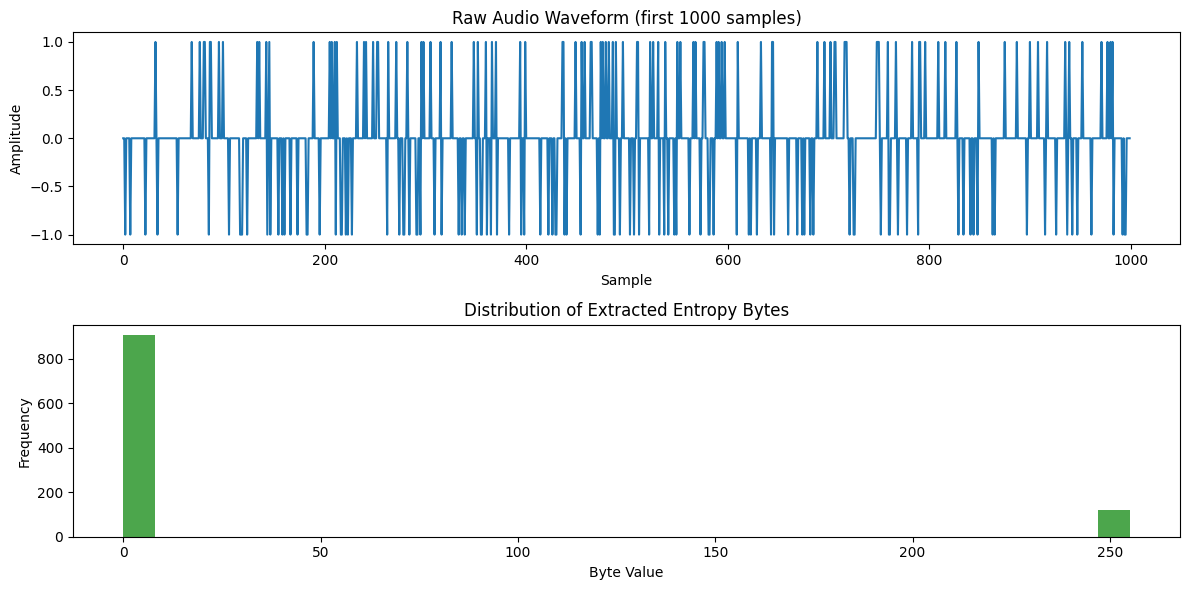

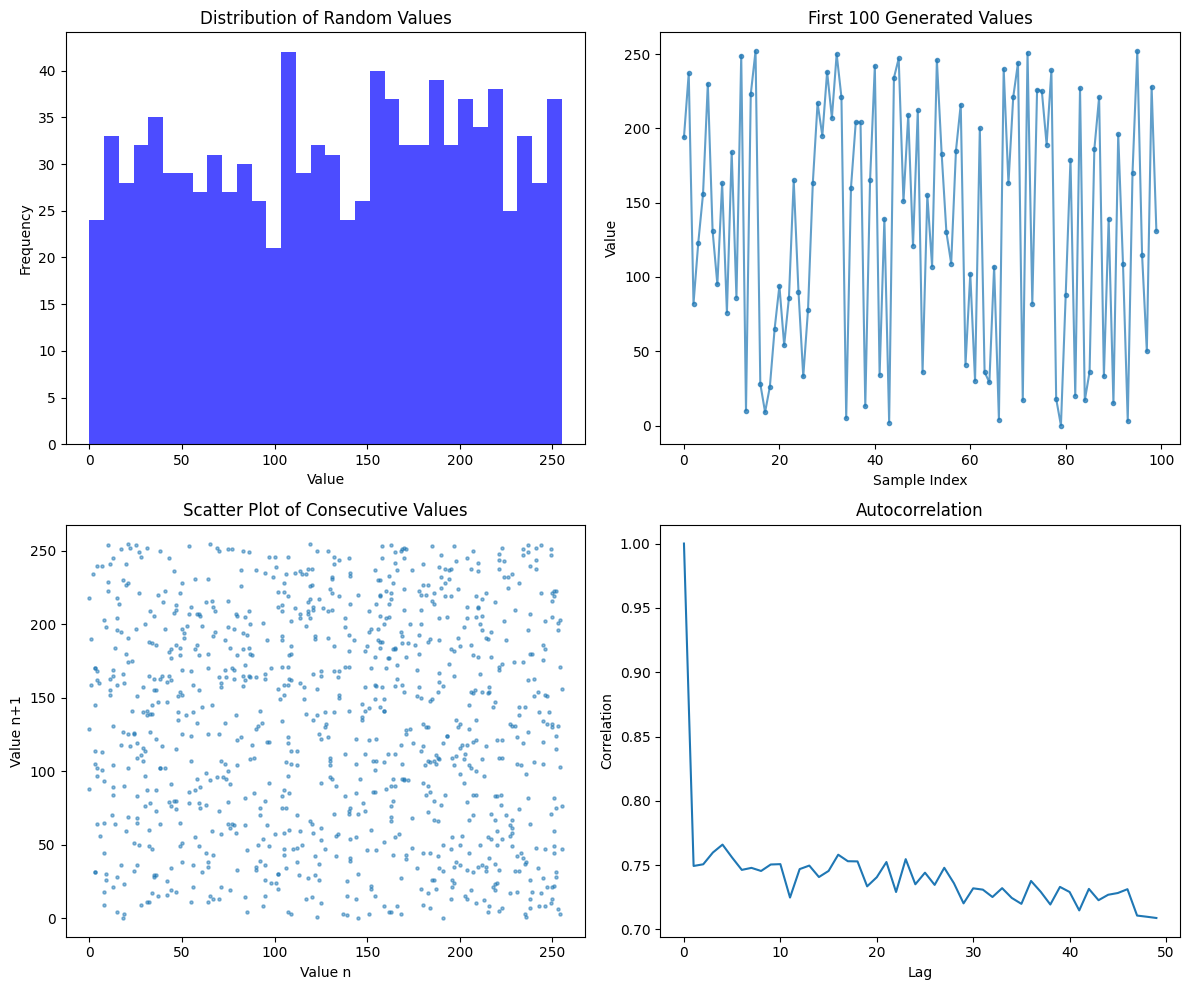

First 10 random numbers: [194, 237, 82, 123, 156, 230, 131, 95, 163, 76]

Rolling a die 20 times:
2 5 1 1 4 5 4 3 4 4 6 6 6 5 2 2 5 6 1 2 

In [8]:
# Example usage
try:
    mic_rng = MicrophoneRNG()
    
    # Collect and visualize raw entropy
    mic_rng.collect_entropy(duration_seconds=.01, visualize=True)
    
    # Generate and visualize random numbers
    random_data = mic_rng.visualize_randomness(1000)
    
    print(f"First 10 random numbers: {random_data[:10]}")
    
    # Simulate rolling a die 20 times
    print("\nRolling a die 20 times:")
    for _ in range(20):
        print(mic_rng.get_random_int(1, 6), end=" ")
        
except Exception as e:
    print(f"Error: {e}")
    print("Note: You may need to install pyaudio: pip install pyaudio")
    print("On some systems, you may need additional libraries:")
    print("  - Windows: pip install pipwin, then pipwin install pyaudio")
    print("  - macOS: brew install portaudio, then pip install pyaudio")
    print("  - Linux: sudo apt-get install python3-pyaudio or equivalent")

### Part C: Things Are Heating Up!

In [9]:
# Package Imports
%pip install psutil
import psutil
import platform

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
class ThermalRNG:
    def __init__(self, pool_size=256):
        self.entropy_pool = deque(maxlen=pool_size)
        self.pool_size = pool_size
        self.temperature_history = []
        self.has_temperature_sensor = self._check_sensor_availability()
    
    def _check_sensor_availability(self):
        """Check if temperature sensors are available"""
        try:
            # Try to get temperatures
            temps = self._get_temperature_data()
            return len(temps) > 0
        except:
            return False
    
    def _get_temperature_data(self):
        """Get temperature data from system sensors"""
        try:
            if platform.system() == 'Windows':
                %pip install wmi
                import wmi
                w = wmi.WMI(namespace="root\\wmi")
                temperature_info = w.MSAcpi_ThermalZoneTemperature()
                temps = [float(item.CurrentTemperature) / 10.0 - 273.15 for item in temperature_info]
                return temps
            elif platform.system() == 'Linux':
                # Use psutil on Linux
                temperatures = psutil.sensors_temperatures()
                temps = []
                for name, entries in temperatures.items():
                    for entry in entries:
                        if entry.current is not None:
                            temps.append(entry.current)
                return temps
            elif platform.system() == 'Darwin':  # macOS
                # macOS temperature requires additional libraries
                # This is a simplified fallback using CPU metrics as a proxy for temperature
                cpu_percent = psutil.cpu_percent(interval=0.1, percpu=True)
                return cpu_percent  # Using CPU load as a proxy for temperature
            else:
                return []
        except Exception as e:
            print(f"Error getting temperature data: {e}")
            return []
    
    def _get_system_load(self):
        """Get system load information as a source of entropy"""
        data = []
        
        # CPU usage
        cpu_percent = psutil.cpu_percent(interval=0.1, percpu=True)
        data.extend(cpu_percent)
        
        # Memory usage
        memory = psutil.virtual_memory()
        data.append(memory.percent)
        
        # Disk usage
        disk = psutil.disk_usage('/')
        data.append(disk.percent)
        
        # Network IO counters
        net = psutil.net_io_counters()
        data.extend([net.bytes_sent % 256, net.bytes_recv % 256])
        
        return data
 
    def collect_entropy(self, iterations=10, delay=0.1):
        """Collect entropy from temperature and system metrics"""
        print("Collecting entropy from system metrics...")
        
        raw_entropy = []
        
        for _ in range(iterations):
            temps = self._get_temperature_data()

            # If temperature sensors are available, use them
            if temps and len(temps) > 0:
                self.has_temperature_sensor = True
                for temp in temps:
                    # Extract fractional part of temperature (most random part)
                    frac_part = int((temp % 1) * 256)
                    lsb = frac_part & 0xFF
                    # hint: bitwise ops, just like in Part A 

                    raw_entropy.append(lsb)
                    self.temperature_history.append(temp)
            
            # Always collect system load data as additional entropy
            system_data = self._get_system_load()
            for value in system_data:
                # Extract least significant bits
                lsb = int(value) & 0xFF
                # hint: bitwise ops, just like in Part A

                raw_entropy.append(lsb)
            
            # Small delay to allow for changes in system state
            time.sleep(delay)
        
        # Add to entropy pool
        for value in raw_entropy:
            self.entropy_pool.append(value)
        
        return raw_entropy
    def ensure_entropy(self, min_required=128):
        """Ensure we have enough entropy in the pool"""
        if len(self.entropy_pool) < min_required:
            self.collect_entropy(iterations=max(1, (min_required - len(self.entropy_pool)) // 10))
    
    def get_random_bytes(self, num_bytes=32):
        """Generate random bytes from the entropy pool"""
        # Make sure we have enough entropy
        self.ensure_entropy(num_bytes * 2)
        
        # Mix entropy with SHA-256
        h = hashlib.sha256()
        h.update(bytes(self.entropy_pool))
        
        # Get a seed from the hash
        seed = h.digest()
        
        # Generate additional random bytes using the seed
        result = bytearray()
        counter = 0
        
        while len(result) < num_bytes:
            # Create a unique input for each iteration
            h = hashlib.sha256()
            h.update(seed)
            h.update(counter.to_bytes(4, byteorder='big'))
            result.extend(h.digest())
            counter += 1
        
        # Collect more entropy for future use
        self.collect_entropy(iterations=2)
        
        return bytes(result[:num_bytes])
    
    def get_random_int(self, min_val=0, max_val=100):
        """Generate a random integer between min_val and max_val (inclusive)"""
        range_size = max_val - min_val + 1
        if range_size <= 0:
            raise ValueError("Invalid range")
        
        # Calculate how many bits we need
        bits_needed = range_size.bit_length()
        bytes_needed = (bits_needed + 7) // 8
        
        # Get random bytes
        random_bytes = self.get_random_bytes(bytes_needed)
        
        # Convert to integer and map to our range
        value = int.from_bytes(random_bytes, byteorder='big')
        return min_val + (value % range_size)
    
    def analyze_entropy_source(self):
        """Analyze and visualize the entropy sources"""
        # Collect some entropy first
        if len(self.entropy_pool) < 100:
            self.collect_entropy(iterations=20)
        
        # Convert deque to list for analysis
        entropy_data = list(self.entropy_pool)
        
        # Create plots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Histogram of entropy values
        axs[0, 0].hist(entropy_data, bins=50, density=True, alpha=0.7)
        axs[0, 0].set_title('Distribution of Entropy Values')
        axs[0, 0].set_xlabel('Value')
        axs[0, 0].set_ylabel('Frequency')
        axs[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Time series of values
        axs[0, 1].plot(entropy_data, '-o', markersize=3, alpha=0.7)
        axs[0, 1].set_title('Entropy Values over Collection Period')
        axs[0, 1].set_xlabel('Sample Index')
        axs[0, 1].set_ylabel('Value')
        axs[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Temperature history if available
        if self.has_temperature_sensor and len(self.temperature_history) > 0:
            axs[1, 0].plot(self.temperature_history, '-o', markersize=3, color='red', alpha=0.7)
            axs[1, 0].set_title('Temperature History')
            axs[1, 0].set_xlabel('Sample Index')
            axs[1, 0].set_ylabel('Temperature (°C)')
            axs[1, 0].grid(True, alpha=0.3)
        else:
            axs[1, 0].text(0.5, 0.5, 'No temperature data available', 
                          horizontalalignment='center', verticalalignment='center',
                          transform=axs[1, 0].transAxes, fontsize=14)
        
        # Plot 4: Autocorrelation (to check for patterns)
        if len(entropy_data) > 10:
            max_lag = min(50, len(entropy_data) // 2)
            autocorr = [np.corrcoef(entropy_data[:-i], entropy_data[i:])[0, 1] 
                        if i > 0 else 1.0 for i in range(max_lag)]
            
            axs[1, 1].bar(range(max_lag), autocorr, alpha=0.7)
            axs[1, 1].set_title('Autocorrelation Analysis')
            axs[1, 1].set_xlabel('Lag')
            axs[1, 1].set_ylabel('Correlation Coefficient')
            axs[1, 1].grid(True, alpha=0.3)
            
            # Add horizontal lines for significance levels (roughly 95% confidence)
            sig_level = 1.96 / np.sqrt(len(entropy_data))
            axs[1, 1].axhline(y=sig_level, color='r', linestyle='--', alpha=0.5)
            axs[1, 1].axhline(y=-sig_level, color='r', linestyle='--', alpha=0.5)
        else:
            axs[1, 1].text(0.5, 0.5, 'Not enough data for autocorrelation', 
                          horizontalalignment='center', verticalalignment='center',
                          transform=axs[1, 1].transAxes, fontsize=14)
        
        plt.tight_layout()
        plt.show()
        
        # Basic statistical analysis
        print("\nEntropy Source Analysis:")
        print(f"Number of samples: {len(entropy_data)}")
        if len(entropy_data) > 0:
            print(f"Mean: {np.mean(entropy_data):.2f}")
            print(f"Standard Deviation: {np.std(entropy_data):.2f}")
            print(f"Min: {np.min(entropy_data)}")
            print(f"Max: {np.max(entropy_data)}")
        
        # Run basic entropy tests if enough data
        if len(entropy_data) >= 100:
            # Simple frequency test (values should be roughly uniformly distributed)
            hist, _ = np.histogram(entropy_data, bins=16, range=(0, 255))
            chi_squared = np.sum((hist - len(entropy_data)/16)**2 / (len(entropy_data)/16))
            print(f"\nChi-squared uniformity test: {chi_squared:.2f}")
            print("(Lower values suggest better uniformity)")
            
            # Serial correlation test
            serial_corr = np.corrcoef(entropy_data[:-1], entropy_data[1:])[0, 1]
            print(f"Serial correlation: {serial_corr:.4f}")
            print("(Values close to zero suggest good randomness)")
        
        return entropy_data
    
    def generate_random_sequence(self, length=100, min_val=0, max_val=255):
        """Generate a sequence of random numbers"""
        return [self.get_random_int(min_val, max_val) for _ in range(length)]

In [ ]:
# Create an instance of ThermalRNG
thermal_rng = ThermalRNG()

# Collect some initial entropy
thermal_rng.collect_entropy(iterations=5)

# Generate 20 random numbers between 0 and 100
random_data = [thermal_rng.get_random_int(0, 100) for _ in range(20)]
print(f"First 10 random numbers: {random_data[:10]}")

# Simulate rolling a die 20 times
print("\nRolling a die 20 times:")
for _ in range(20):
    print(thermal_rng.get_random_int(1, 6), end=" ")
print()

# Generate random bytes
random_bytes = thermal_rng.get_random_bytes(16)
print(f"\nRandom bytes (hex): {random_bytes.hex()}")

# Quick coin flip simulation (10 flips)
print("\nFlipping a coin 10 times (0=Heads, 1=Tails):")
for _ in range(10):
    print("H" if thermal_rng.get_random_int(0, 1) == 0 else "T", end=" ")
print()

# Generate a number from a larger range
big_number = thermal_rng.get_random_int(1, 1000000)
print(f"\nRandom number between 1 and 1,000,000: {big_number}")